## Семинар 5: "Улучшение сходимости нейросетей"

## Ильин Илья Юрьевич

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

## Описание задания:
Вам необходимо реализовать оставшиеся методы из лекции и сравнить их на примере из семинара.

## Задание разделено на следующие части:
1. Реализация Xavier **(1 балл)**

2.1 Реализация DropConnect **(1 балл)**

2.2 Сравнение обучения при использовании Dropout и DropConnect **(1 балл)**

3.1 Реализация LayerNorm **(1 балл)**

3.2 Сравнение обучения при использовании BatchNorm и LayerNorm **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 17 октября.


### Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [67]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [68]:
images_train, labels_train = next(iter(train_loader))

In [69]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

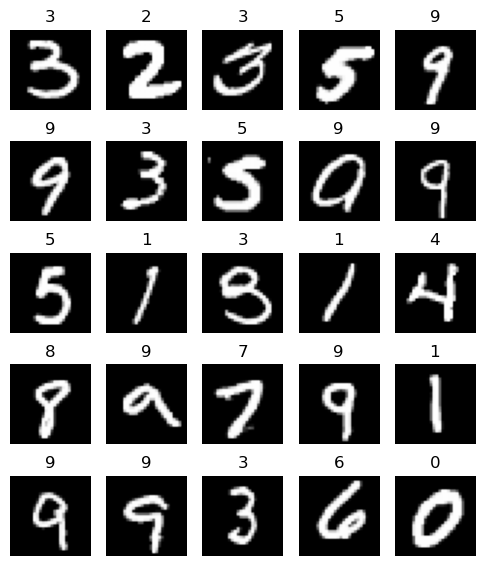

In [70]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [71]:
def init_layer(layer, a, b):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.uniform_(a, b)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

На вход передаем изображение 28x28, на выходе -- вероятности 10 классов.

In [72]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1)
init_layer(layer_2)

TypeError: init_layer() missing 2 required positional arguments: 'a' and 'b'

Соберем все вместе, используя ReLU в качестве функции активации:

In [73]:
network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

#### 1.1 Реализуйте инициализацию Xavier. Сравните ее с He, которая была реализована на семинаре, сделайте выводы. Учтите, что для Xavier необходимо использовать функцию активации nn.Tanh(). **(1 балл)**

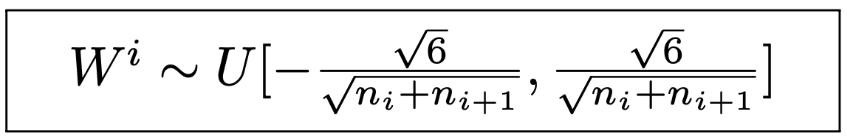

In [74]:
import math
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

num1 = math.sqrt(6)/math.sqrt(28*28+500)
num2 = math.sqrt(6)/math.sqrt(500+10)

init_layer(layer_1, -num1, num1)
init_layer(layer_2, -num2, num2)

In [75]:
network = nn.Sequential(
    layer_1,
    nn.Tanh(),
    layer_2
)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 0.98238205909729
forward 0.6429775953292847
backward 0.033665016293525696
backward 0.014011865481734276


## Часть 2: DropConnect

#### 2.1 Реализуйте DropConnect по следующему шаблону: **(1 балл)**

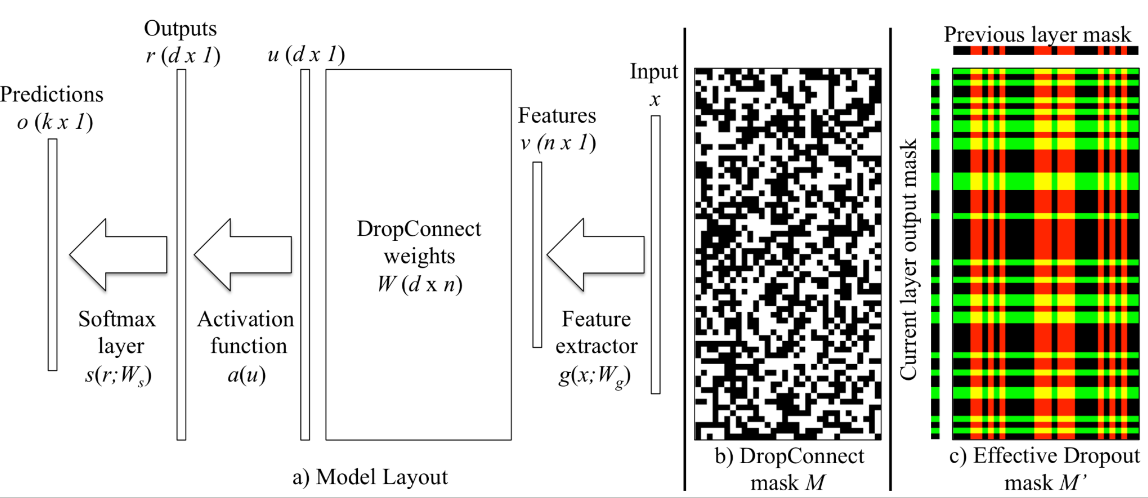

In [26]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.empty(self.linear.weight.shape).bernoulli_(1 - self.p).requires_grad_(False)
        else:
            mask = torch.ones(self.linear.weight.shape)

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

Основа для сети, которую будем обучать:

In [27]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Добавим несколько слоев в конец сети:

In [32]:
layers = [
    nn.Linear(196, 128),
    nn.ReLU(),
    DropConnect(128,128),
    nn.ReLU(),
    DropConnect(128,10),
]

In [33]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

Обучим получившуюся сеть:

In [34]:
for epoch in range(10):
    network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())

    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.295558
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.907286
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.728423
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.374401
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.449447


KeyboardInterrupt: 


#### 2.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.296791
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.242049
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.816418
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.658422
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.531779
Test Epoch: 0	Loss: 0.691988
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.524014
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.678732
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.336603
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.288447
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.260948
Test Epoch: 1	Loss: 0.453182
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.231521
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.294484
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.216683
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.226798
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.166022
Test Epoch: 2	Loss: 0.349056
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.282799
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.184000
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.294602
Train Epoch: 3 [38400/60000 (64%)

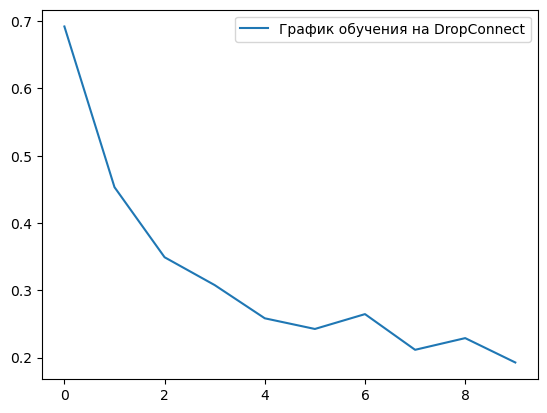

In [51]:
layers = [
    nn.Linear(196, 128),
    nn.ReLU(),
    DropConnect(128,128),
    nn.ReLU(),
    DropConnect(128,10),
]

network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()
losses_mean = []
for epoch in range(10):
    network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data

        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())
        
    losses_mean.append(np.mean(losses))
    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))
plt.plot(losses_mean, label = "График обучения на DropConnect")
plt.legend()
plt.show()

In [53]:
class Dropout(nn.Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x):
        mask = torch.empty(x.shape).uniform_(0, 1).type(torch.FloatTensor)
        if self.training:
            mask = torch.where(mask > self.p, 1, 0)
        else:
            mask = torch.where(mask > self.p, 1, 1 - self.p)

        return x * mask

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.307748
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.013323
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.711339
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.468914
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.348293
Test Epoch: 0	Loss: 0.308279
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.427640
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.299222
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.309019
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.239337
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.247877
Test Epoch: 1	Loss: 0.217429
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.178751
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.248164
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.236919
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.175916
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.374135
Test Epoch: 2	Loss: 0.184960
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.157841
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.102600
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.189948
Train Epoch: 3 [38400/60000 (64%)

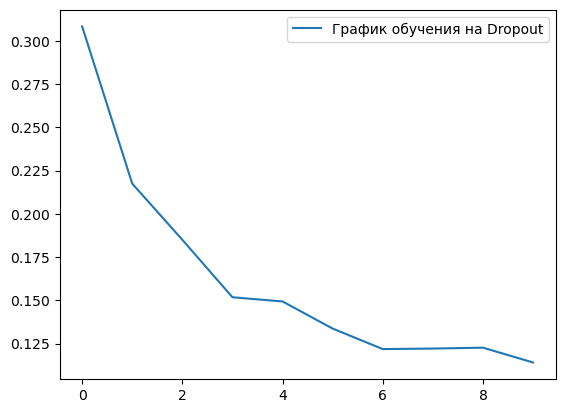

In [54]:
layers = [
    nn.Linear(196, 128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128, 128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128, 10)
]

network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()
losses_mean = []

for epoch in range(10):
    network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        losseses = 0

        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())
        
    losses_mean.append(np.mean(losses))
    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))
plt.plot(losses_mean, label = "График обучения на Dropout")
plt.legend()
plt.show()

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

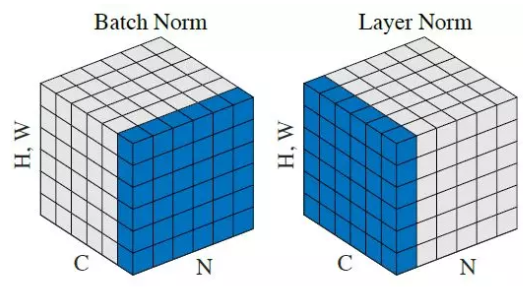

#### 3.1 Реализуйте Layer Normalization **(1 балл)**

In [76]:
class LayerNormalization(nn.Module):
    def forward(self, x):
        output = x - x.mean(dim=-1, keepdim=True)
        output = output / x.std(dim=-1, keepdim=True)
        return output


In [92]:
class MyBatchNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(MyBatchNorm, self).__init__()
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.running_mean = torch.zeros(num_features)
        self.running_var = torch.ones(num_features)


    def forward(self, input):
        if self.training:
            mean = input.mean([0, -2, -1])
            var = input.var([0, -2, -1], unbiased=False)

            with torch.no_grad():
                self.running_mean = self.momentum * mean + (1 - self.momentum) * self.running_mean
                self.running_var = self.momentum * var + (1 - self.momentum) * self.running_var
        else:
            mean = self.running_mean
            var = self.running_var

        input = (input - mean[None, :, None, None]) / (torch.sqrt(var[None, :, None, None] + self.eps))
        return input

#### 3.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.526518
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.294984
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.170162
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.174080
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.117890
Test Epoch: 0	Loss: 0.109359
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.090950
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.082830
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.081500
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.137987
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.066258
Test Epoch: 1	Loss: 0.089440
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.120159
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.059089
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.061819
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.092840
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.118067
Test Epoch: 2	Loss: 0.077215
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.044729
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.057740
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.045754
Train Epoch: 3 [38400/60000 (64%)

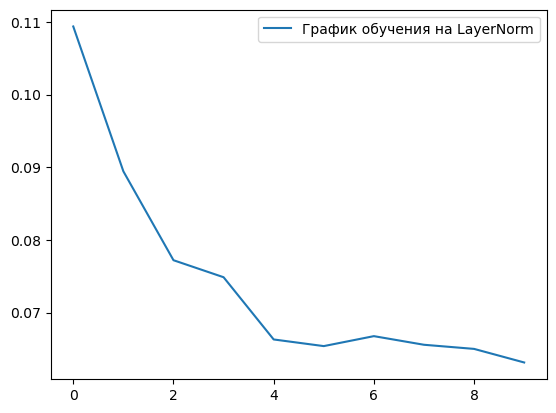

In [82]:
layers = [
    nn.Linear(196, 128),
    nn.ReLU(),
    LayerNormalization(),
    nn.Linear(128, 128),
    nn.ReLU(),
    LayerNormalization(),
    nn.Linear(128, 10)
]

network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()
losses_mean = []

for epoch in range(10):
    network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        losseses = 0

        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())
        
    losses_mean.append(np.mean(losses))
    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))
plt.plot(losses_mean, label = "График обучения на LayerNorm")
plt.legend()
plt.show()

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.542699
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.239891
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.171653
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.285792
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.067508
Test Epoch: 0	Loss: 0.095590
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.130724
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.055868
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.052759
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.046187
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.066646
Test Epoch: 1	Loss: 0.070262
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.027190
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.064371
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.052108
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.051876
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.040426
Test Epoch: 2	Loss: 0.059168
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.067988
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.034420
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.032353
Train Epoch: 3 [38400/60000 (64%)

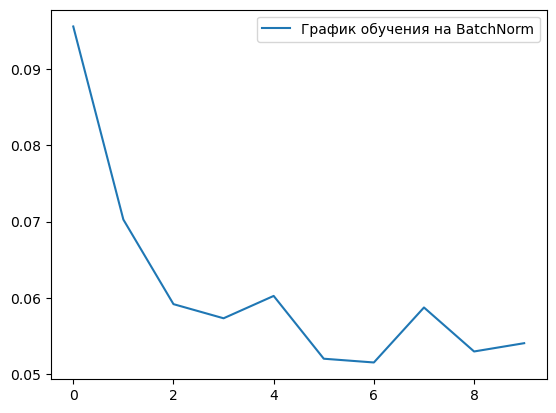

In [100]:
layers = [
    nn.Linear(196, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Linear(128, 10)
]

network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()
losses_mean = []

for epoch in range(10):
    network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        losseses = 0

        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())
        
    losses_mean.append(np.mean(losses))
    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))
plt.plot(losses_mean, label = "График обучения на BatchNorm")
plt.legend()
plt.show()